In [1]:
from glassnode import GlassnodeClient
import pandas as pd
import numpy as np
import requests
import sys; sys.path.append("..")
from trader.data.univ import Universe

In [2]:
univ = Universe()
yay = univ.coins.index.to_list()

## Metrics needed
       Addresses
        - count
        - active_count
        - new_non_zero_count
       Transactions
        - count
        - rate
        - size_mean
        - size_sum
        - transfers_count - one transaction can create >= 1 transfers
        - transfers_rate
        - transfers_volume_sum
        - transfers_volume_mean
       Market
        - price_usd_close
        - marketcap_usd
       Distribution
        - balance_exchanges
        - balance_1pct_holders - Supply of top 1% addresses
        - gini - what is this?
        - herfindahl - measures decentralization
       Supply
        - current - current supply

In [3]:
import configparser


In [7]:
class GlassNode:
    def __init__(self):
        cfg = configparser.ConfigParser()
        cfg.read(r"../trader/data/config.cfg")
        self.api_key = cfg.get("KEYS", "glassnode_key") #CHANGE TO CONFIG
        
        self.base_path = "https://api.glassnode.com/v1/metrics/"
        self.paths = {
            "addresses" : self.base_path + "addresses/count",
            "active_addresses" : self.base_path + "addresses/active_count",
            "non_zero_addresses" : self.base_path + "addresses/new_non_zero_count",
            
            "transactions_count" : self.base_path + "transactions/count",
            "transactions_rate" : self.base_path + "transactions/rate",
            "transactions_mean" : self.base_path + "transactions/size_mean",
            "transactions_sum" : self.base_path + "transactions/size_sum",
            "transfers_count" : self.base_path + "transactions/transfers_count",
            "transfers_rate" : self.base_path + "transactions/transfers_rate",
            "transfers_sum" : self.base_path + "transactions/transfers_volume_sum",
            "transfers_mean" : self.base_path + "transactions/transfers_volume_mean",
            
            "price" : self.base_path + "market/price_usd_close",
            "mktcap" : self.base_path + "market/marketcap_usd",
            
            "supply" : self.base_path + "supply/current"
        }
        
    def get_metrics(self):
        metrics = requests.get("https://api.glassnode.com/v2/metrics/endpoints", params = {"api_key" : api_key})
        metrics = pd.read_json(metrics.text)
        s = metrics.path.str.split("/")
        s = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
        metrics["Type"] = s[3]
        metrics["Name"] = s[4]
        return metrics
    
    def get(self, assets, metrics=None):
        if isinstance(assets, str):
            assets = [assets]
        if metrics is None:
            metrics = list(self.paths.keys())
        if isinstance(metrics, str):
            metrics = [metrics]
        data = {}
        for asset in assets:
            data_ = {}
            for metric in metrics:
                try:
                    path = self.paths[metric]
                except KeyError as e:
                    print(f"{e} is not a valid metric")
                    continue
                data__ = requests.get(path, params = {"api_key" : self.api_key, "a" : asset.lower()})
                if data__.text == "Too Many Requests":
                    print("Sleeping..")
                    time.sleep(45)
                    print("Trying again")
                    data__ = requests.get(path, params = {"api_key" : self.api_key, "a" : asset.lower()})
                    if data__.text == "Too Many Requests":
                        print(f"skipping {metric} for {asset}")
                        continue
                if len(data__.text) == 2: #means its []
                    print(f"skipping {metric} for {asset}")
                    continue
                #print(data__.text, len(data__.text))
                try:
                    data__ = pd.read_json(data__.text, convert_dates="t").set_index("t").iloc[:,0]
                except:
                    print(f"skipping {metric} for {asset}")
                    print(data__.text)
                    continue
                data_[metric] = data__
            if len(data_) != 0:
                data[asset] = pd.concat(data_, axis=1)
        data = pd.concat(data, axis=1).stack().stack().reset_index()
        data.columns = ["Time", "Metric", "Symbol", "Value"]
        return data
        

In [8]:
gn = GlassNode()


In [9]:
data = gn.get(yay)

skipping transfers_count for btc
skipping transfers_rate for btc
skipping transactions_mean for ltc
skipping transactions_sum for ltc
skipping transfers_count for ltc
skipping transfers_rate for ltc
skipping addresses for bch
unsupported asset BCH

skipping active_addresses for bch
Too Many Requests

skipping non_zero_addresses for bch
Too Many Requests

skipping transactions_count for bch
Too Many Requests

skipping transactions_rate for bch
Too Many Requests

skipping transactions_mean for bch
Too Many Requests

skipping transactions_sum for bch
Too Many Requests

skipping transfers_count for bch
Too Many Requests

skipping transfers_rate for bch
Too Many Requests

skipping transfers_sum for bch
Too Many Requests

skipping transfers_mean for bch
Too Many Requests

skipping price for bch
Too Many Requests

skipping mktcap for bch
Too Many Requests

skipping supply for bch
Too Many Requests

skipping addresses for xlm
Too Many Requests

skipping active_addresses for xlm
Too Many Reques

skipping transactions_sum for sushi
Too Many Requests

skipping transfers_count for sushi
Too Many Requests

skipping transfers_rate for sushi
Too Many Requests

skipping transfers_sum for sushi
Too Many Requests

skipping transfers_mean for sushi
Too Many Requests

skipping price for sushi
Too Many Requests

skipping mktcap for sushi
Too Many Requests

skipping supply for sushi
Too Many Requests

skipping addresses for aave
Too Many Requests

skipping active_addresses for aave
Too Many Requests

skipping non_zero_addresses for aave
Too Many Requests

skipping transactions_count for aave
Too Many Requests

skipping transactions_rate for aave
Too Many Requests

skipping transactions_mean for aave
Too Many Requests

skipping transactions_sum for aave
Too Many Requests

skipping transfers_count for aave
Too Many Requests

skipping transfers_rate for aave
Too Many Requests

skipping transfers_sum for aave
Too Many Requests

skipping transfers_mean for aave
Too Many Requests

skipping price

<AxesSubplot:xlabel='Time'>

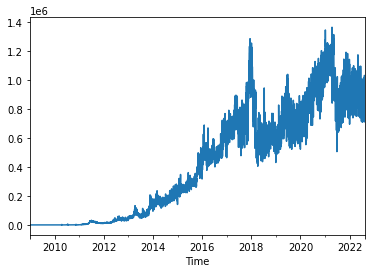

In [13]:
data[(data.Symbol == "btc") & (data.Metric == "active_addresses")].set_index("Time").Value.plot()

In [16]:
data[data.Symbol == "btc"].pivot(index="Time", columns = "Metric", values="Value").diff().corr()

Metric,active_addresses,addresses,mktcap,non_zero_addresses,price,supply,transactions_count,transactions_mean,transactions_rate,transactions_sum,transfers_mean,transfers_sum
Metric,,,,,,,,,,,,
active_addresses,1.000000,0.071591,-0.022285,0.822208,-0.022026,0.006092,0.780011,0.020126,0.780011,0.872637,0.000257,0.121495
addresses,0.071591,1.000000,0.019576,0.087986,0.019763,-0.771246,0.079265,0.001969,0.079265,0.061546,-0.000010,0.007799
mktcap,-0.022285,0.019576,1.000000,0.013781,0.999638,-0.006216,0.004987,-0.030488,0.004987,-0.025750,-0.001787,-0.029139
non_zero_addresses,0.822208,0.087986,0.013781,1.000000,0.014723,0.005289,0.911067,-0.013427,0.911067,0.665454,0.000048,0.135184
price,-0.022026,0.019763,0.999638,0.014723,1.000000,-0.005960,0.005235,-0.030658,0.005235,-0.025480,-0.001774,-0.028757
supply,0.006092,-0.771246,-0.006216,0.005289,-0.005960,1.000000,0.008768,-0.003753,0.008768,0.010716,-0.002969,0.002055
transactions_count,0.780011,0.079265,0.004987,0.911067,0.005235,0.008768,1.000000,-0.015708,1.000000,0.717614,-0.000221,0.136653
transactions_mean,0.020126,0.001969,-0.030488,-0.013427,-0.030658,-0.003753,-0.015708,1.000000,-0.015708,0.039624,0.714827,-0.002028
transactions_rate,0.780011,0.079265,0.004987,0.911067,0.005235,0.008768,1.000000,-0.015708,1.000000,0.717614,-0.000221,0.136653


<AxesSubplot:xlabel='Time'>

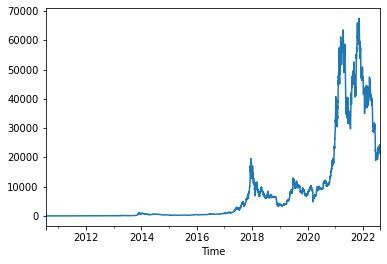

In [14]:
data[(data.Symbol == "btc") & (data.Metric == "price")].set_index("Time").Value.plot()